current_x :  4.185749411582947
current_y :  4.255190372467041
desired_x :  4.242640495300293
desired_y :  4.242640495300293
joint1_angle:  50.63031173704371
joint2_angle:  -2.163444207273187
joint3_angle:  -11.169309311978878


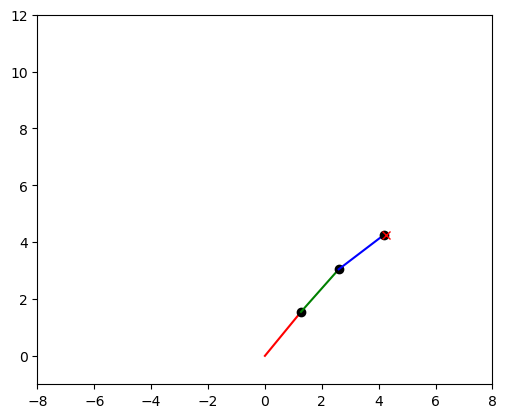

In [15]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
from math import pi, sqrt

def forward_kinematics(theta1, theta2, theta3, l1=2, l2=2, l3=2):
    x = l1*np.cos(theta1) + l2*np.cos(theta1 + theta2) + l3*np.cos(theta1 + theta2 + theta3)
    y = l1*np.sin(theta1) + l2*np.sin(theta1 + theta2) + l3*np.sin(theta1 + theta2 + theta3)
    theta = theta1 + theta2 + theta3

    return x, y, theta

def rad_to_deg(radians):
    degrees = radians * (180 / pi)
    degrees = (degrees + 180) % 360 - 180
    return degrees

class RoboticArmEnv(gym.Env):
    def __init__(self, desired_position):
        super(RoboticArmEnv, self).__init__()

        #state-space [current_x, current_y, desired_x, desired_y, joint1_angle, joint2_angle, joint3_angle]

        self.action_space = spaces.Box(low=-0.3, high=0.3, shape=(3,), dtype=np.float64)  # Joint angle changes
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(7,), dtype=np.float64)  # State space

        self.arm_length = [2, 2, 2]  # Length of links

        # Initialize state
        self.current_position = np.array([0, 0], dtype=np.float64)  # Initial end-effector position
        self.desired_position = desired_position  # Desired end-effector position
        self.joint_angles = np.array([0, 0, 0], dtype=np.float64)   # Initial joint angles

    def step(self, action):
        # print((action))
        # print(self.joint_angles)
        self.joint_angles += action

        x, y, _ = forward_kinematics(self.joint_angles[0], self.joint_angles[1], self.joint_angles[2])
        self.current_position = np.array([x, y], dtype=np.float64)

        # Calculate reward based on distance to desired position
        reward = -np.linalg.norm(self.current_position - self.desired_position)

        # Check if the episode is done
        done = np.linalg.norm(self.current_position - self.desired_position) < 0.1

        # Return state, reward, done, info
        return self._get_obs(), reward, done, {}

    def reset(self, desired_position):
        # Reset arm to initial state
        self.current_position = np.array([0, 0], dtype=np.float32)
        self.desired_position = desired_position
        self.joint_angles = np.array([0, 0, 0], dtype=np.float32)
        return self._get_obs()

    def _get_obs(self):
        # Return current state
        return np.concatenate((self.current_position, self.desired_position, self.joint_angles))

if __name__ == "__main__":
    desired_position = np.array([6/sqrt(2), 6/sqrt(2)], dtype=np.float32)

    env = RoboticArmEnv(desired_position)
    obs = env.reset(desired_position)
    total_reward = 0
    done = False
    while not done:
        action = env.action_space.sample()
        obs, reward, done, _ = env.step(action)
        total_reward += reward

        # print("Action:", action, "Observation:", obs, "Reward:", reward)
    # print("Total Reward:", total_reward)
    for i, j in zip(['current_x', 'current_y', 'desired_x', 'desired_y', 'joint1_angle', 'joint2_angle', 'joint3_angle'], obs):
        
        if i == 'joint1_angle':
            print("joint1_angle: ", rad_to_deg(j))
        elif i == 'joint2_angle':
            print("joint2_angle: ", rad_to_deg(j))
        elif i == 'joint3_angle':
            print("joint3_angle: ", rad_to_deg(j))
        else:
            print(i, ": ", j)

    # print(obs)
    # print(obs[-3:])
    

    joint_angles = obs[-3:]

    desired_position = obs[2:4]
    arm_length = [2, 2, 2]
    plt.figure()
    plt.plot([0, arm_length[0]*np.cos(joint_angles[0])],
                [0, arm_length[0]*np.sin(joint_angles[0])], 'r-')
    plt.plot([arm_length[0]*np.cos(joint_angles[0])],
                [arm_length[0]*np.sin(joint_angles[0])], 'ko')
    plt.plot([arm_length[0]*np.cos(joint_angles[0]),
                arm_length[0]*np.cos(joint_angles[0]) + arm_length[1]*np.cos(joint_angles[0] + joint_angles[1])],
                [arm_length[0]*np.sin(joint_angles[0]),
                arm_length[0]*np.sin(joint_angles[0]) + arm_length[1]*np.sin(joint_angles[0] + joint_angles[1])], 'g-')
    plt.plot([arm_length[0]*np.cos(joint_angles[0]) + arm_length[1]*np.cos(joint_angles[0] + joint_angles[1])],
                [arm_length[0]*np.sin(joint_angles[0]) + arm_length[1]*np.sin(joint_angles[0] + joint_angles[1])], 'ko')
    plt.plot([arm_length[0]*np.cos(joint_angles[0]) + arm_length[1]*np.cos(joint_angles[0] + joint_angles[1]),
                arm_length[0]*np.cos(joint_angles[0]) + arm_length[1]*np.cos(joint_angles[0] + joint_angles[1]) + arm_length[2]*np.cos(joint_angles[0] + joint_angles[1] + joint_angles[2])],
                [arm_length[0]*np.sin(joint_angles[0]) + arm_length[1]*np.sin(joint_angles[0] + joint_angles[1]),
                arm_length[0]*np.sin(joint_angles[0]) + arm_length[1]*np.sin(joint_angles[0] + joint_angles[1]) + arm_length[2]*np.sin(joint_angles[0] + joint_angles[1] + joint_angles[2])], 'b-')
    plt.plot([arm_length[0]*np.cos(joint_angles[0]) + arm_length[1]*np.cos(joint_angles[0] + joint_angles[1]) + arm_length[2]*np.cos(joint_angles[0] + joint_angles[1] + joint_angles[2])],
                [arm_length[0]*np.sin(joint_angles[0]) + arm_length[1]*np.sin(joint_angles[0] + joint_angles[1]) + arm_length[2]*np.sin(joint_angles[0] + joint_angles[1] + joint_angles[2])], 'ko')
    plt.plot(desired_position[0], desired_position[1], 'rx')
    plt.xlim(-8, 8)
    plt.ylim(-1, 12)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()  

# Trajectory following

current_x :  5.972768664360046
current_y :  -0.04110629064962268
desired_x :  6.0
desired_y :  0.0
joint1_angle:  6.174888070147745
joint2_angle:  -6.369434626516352
joint3_angle:  -6.969786399766235


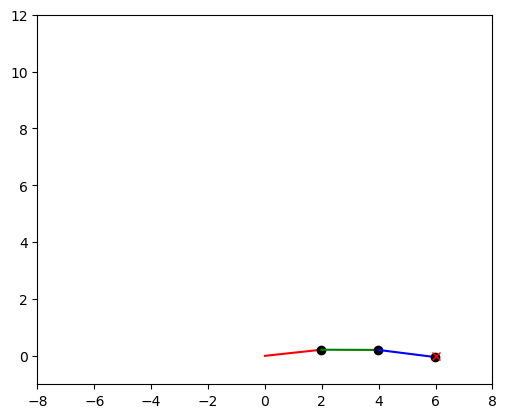

current_x :  5.970294237136841
current_y :  0.4681585505604744
desired_x :  5.98792028427124
desired_y :  0.3805435299873352
joint1_angle:  1.8852842985820644
joint2_angle:  7.589913839846304
joint3_angle:  -7.379989344460682


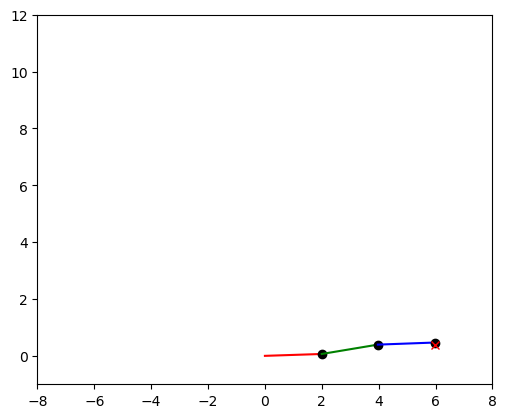

current_x :  5.908377647399902
current_y :  0.6987328231334686
desired_x :  5.951728820800781
desired_y :  0.7595547437667847
joint1_angle:  10.706452661815547
joint2_angle:  2.470454835018245
joint3_angle:  -16.8675501298153


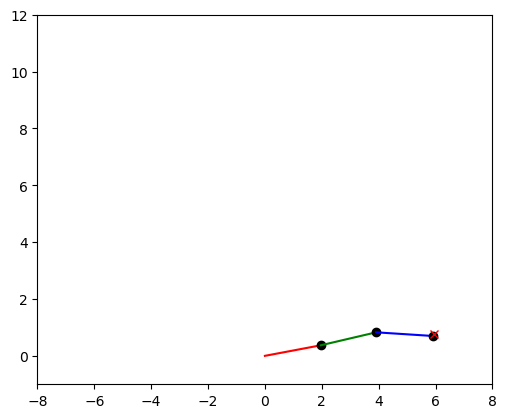

current_x :  5.886455655097961
current_y :  1.0799289047718048
desired_x :  5.891571998596191
desired_y :  1.1355074644088745
joint1_angle:  4.604548350673099
joint2_angle:  8.674521473300274
joint3_angle:  0.017540986335546904


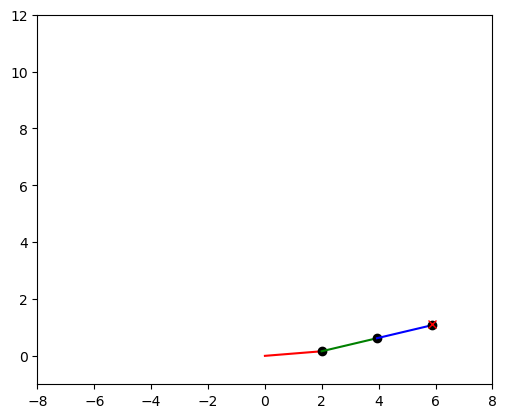

current_x :  5.809584856033325
current_y :  1.458840698003769
desired_x :  5.807692050933838
desired_y :  1.5068879127502441
joint1_angle:  15.292950646009473
joint2_angle:  -5.724605232083007
joint3_angle:  7.855745488984752


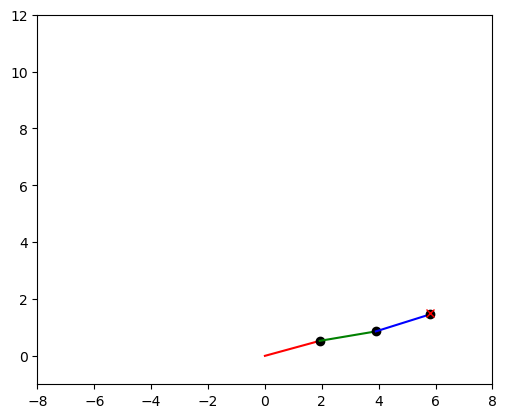

current_x :  5.643253922462463
current_y :  1.8989548683166504
desired_x :  5.7004265785217285
desired_y :  1.8722007274627686
joint1_angle:  8.779729155325185
joint2_angle:  16.499410218483035
joint3_angle:  -3.575082203143438


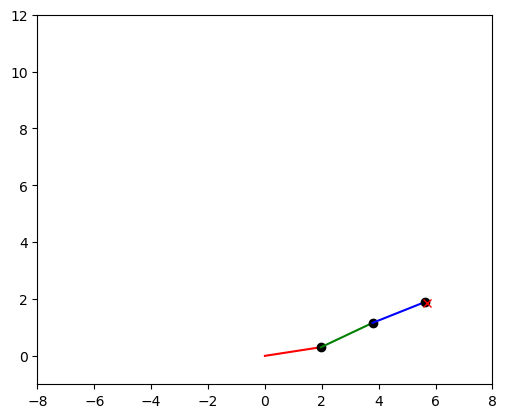

current_x :  5.554072856903076
current_y :  2.1813575625419617
desired_x :  5.570207595825195
desired_y :  2.2299747467041016
joint1_angle:  29.584954371997583
joint2_angle:  -10.098183335091107
joint3_angle:  -4.216291258524052


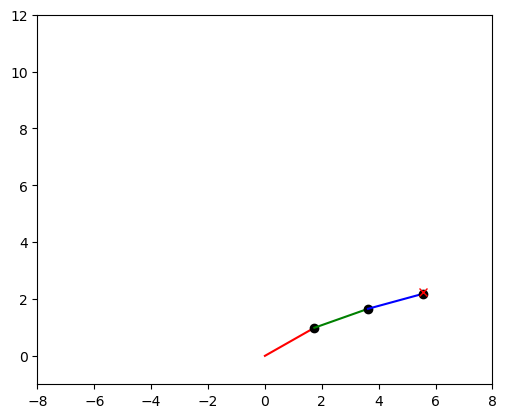

current_x :  5.3977742195129395
current_y :  2.4890818297863007
desired_x :  5.4175591468811035
desired_y :  2.5787694454193115
joint1_angle:  32.72527682214127
joint2_angle:  -18.628200774360607
joint3_angle:  13.313542187745895


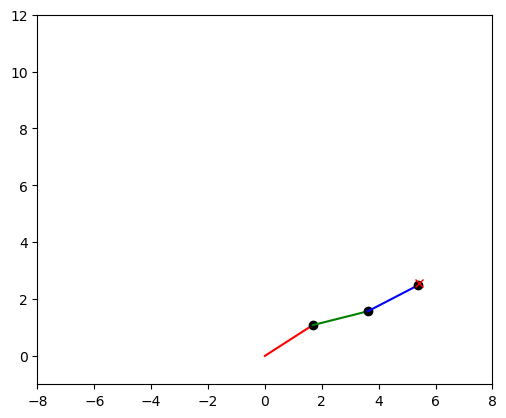

current_x :  5.23691987991333
current_y :  2.8650689721107483
desired_x :  5.243096351623535
desired_y :  2.917180299758911
joint1_angle:  36.03884474234326
joint2_angle:  -14.14537914559105
joint3_angle:  6.226477857703685


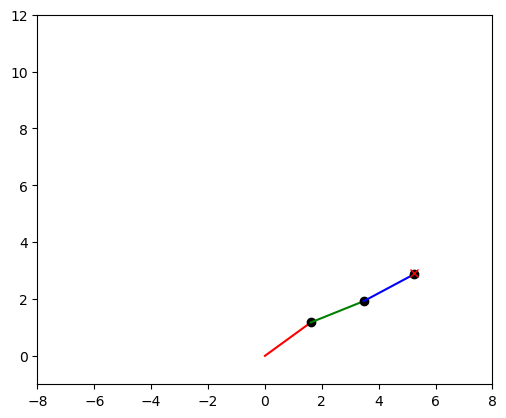

current_x :  5.008549213409424
current_y :  3.22325998544693
desired_x :  5.047521114349365
desired_y :  3.243844985961914
joint1_angle:  40.578320516567146
joint2_angle:  -6.595481101324367
joint3_angle:  -10.267465476461894


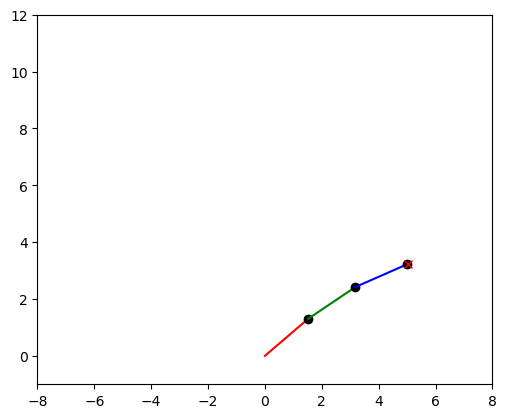

current_x :  4.753746151924133
current_y :  3.6106196641921997
desired_x :  4.8316216468811035
desired_y :  3.557447671890259
joint1_angle:  29.035383463628904
joint2_angle:  12.444132929968305
joint3_angle:  -0.36187070715857317


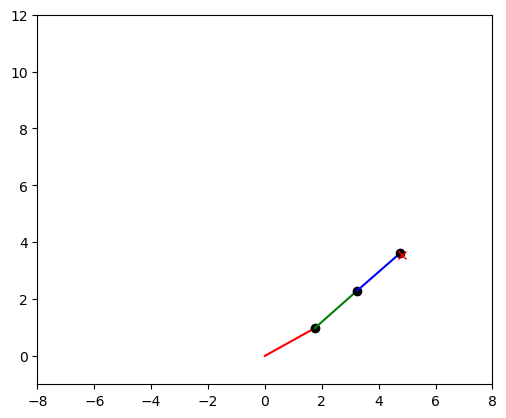

current_x :  4.504151821136475
current_y :  3.887539267539978
desired_x :  4.596266746520996
desired_y :  3.8567256927490234
joint1_angle:  42.78418566002051
joint2_angle:  5.927442157927771
joint3_angle:  -17.83873745635242


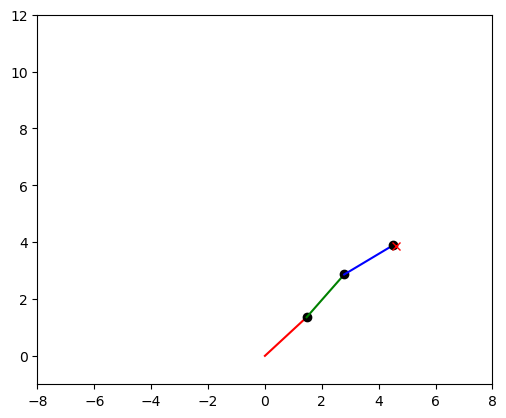

current_x :  4.298144817352295
current_y :  4.155309557914734
desired_x :  4.342404365539551
desired_y :  4.14047384262085
joint1_angle:  42.26396839909421
joint2_angle:  -3.1072643345609094
joint3_angle:  11.52713358679648


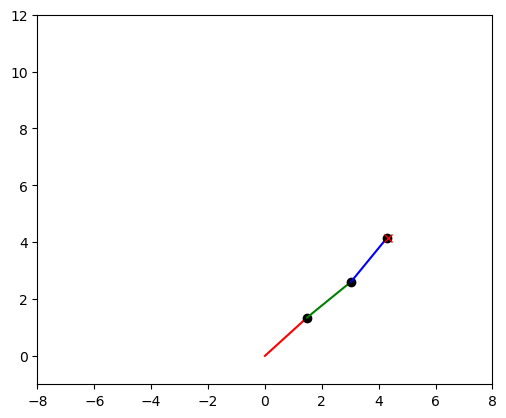

current_x :  3.9961854219436646
current_y :  4.366659045219421
desired_x :  4.071056365966797
desired_y :  4.40755033493042
joint1_angle:  37.269514602443195
joint2_angle:  22.753908240615033
joint3_angle:  -14.66347722437763


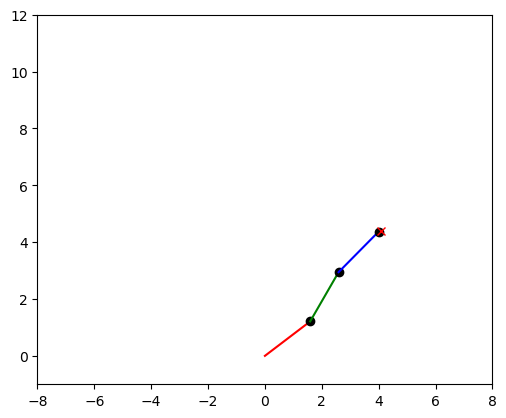

current_x :  3.739137053489685
current_y :  4.642504096031189
desired_x :  3.783315896987915
desired_y :  4.65687894821167
joint1_angle:  57.858730989406126
joint2_angle:  -4.570618703857804
joint3_angle:  -10.999808377183399


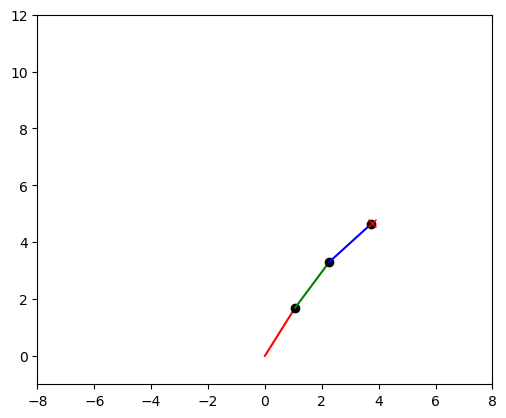

current_x :  3.4063855409622192
current_y :  4.843037724494934
desired_x :  3.4803414344787598
desired_y :  4.887455940246582
joint1_angle:  43.07768708307185
joint2_angle:  12.623532855210897
joint3_angle:  10.14071720129192


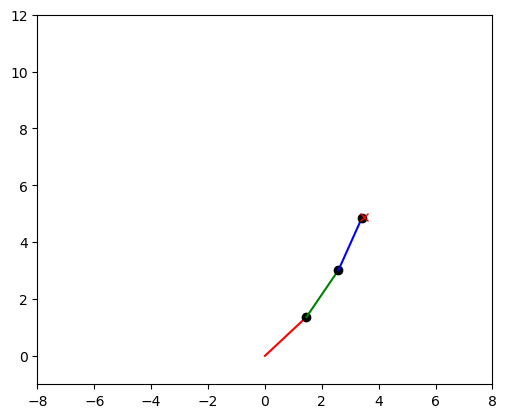

current_x :  3.10750812292099
current_y :  5.05767035484314
desired_x :  3.1633527278900146
desired_y :  5.098352432250977
joint1_angle:  50.468615662129764
joint2_angle:  19.553445520087166
joint3_angle:  -15.1634252168285


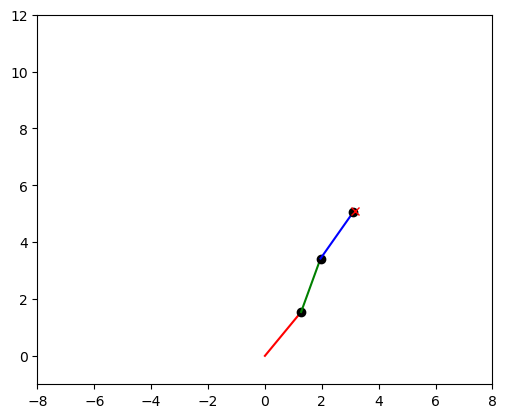

current_x :  2.809349477291107
current_y :  5.213768720626831
desired_x :  2.8336265087127686
desired_y :  5.28872013092041
joint1_angle:  59.41568353810749
joint2_angle:  14.546085398886134
joint3_angle:  -22.24798520139518


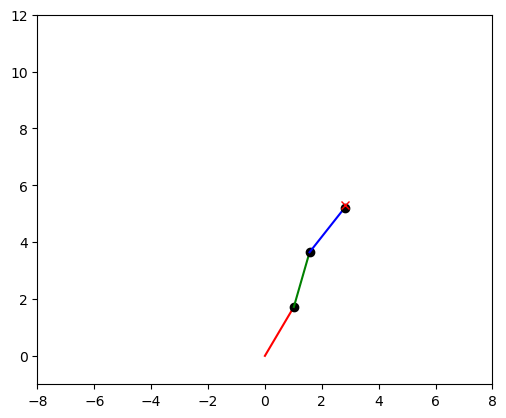

current_x :  2.4614404439926147
current_y :  5.365727424621582
desired_x :  2.49249005317688
desired_y :  5.457791805267334
joint1_angle:  76.51759111872434
joint2_angle:  -24.864094275206185
joint3_angle:  16.18877264433894


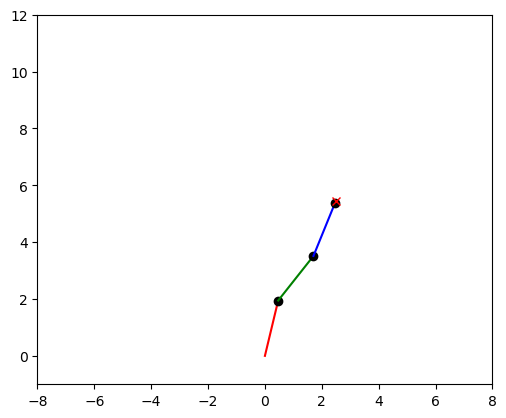

current_x :  2.0922568142414093
current_y :  5.530572295188904
desired_x :  2.141317367553711
desired_y :  5.604887008666992
joint1_angle:  72.63957363253121
joint2_angle:  6.523581068686553
joint3_angle:  -23.200426850912436


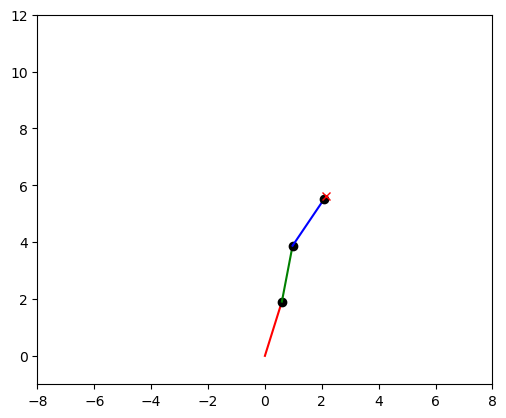

current_x :  1.7968047559261322
current_y :  5.666502237319946
desired_x :  1.781522274017334
desired_y :  5.7294135093688965
joint1_angle:  69.12271651382298
joint2_angle:  14.059907067801873
joint3_angle:  -18.227606537073598


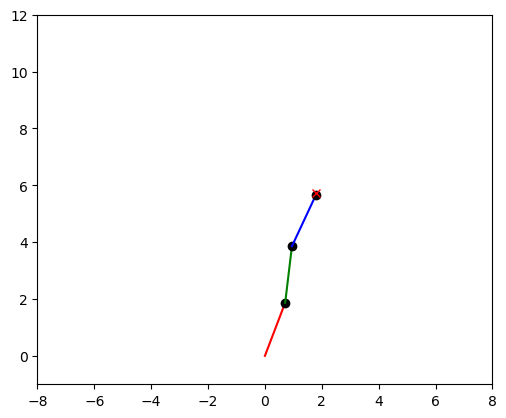

current_x :  1.426478385925293
current_y :  5.811883449554443
desired_x :  1.4145536422729492
desired_y :  5.830869197845459
joint1_angle:  77.43190118633191
joint2_angle:  -6.788043260368113
joint3_angle:  9.905388782483556


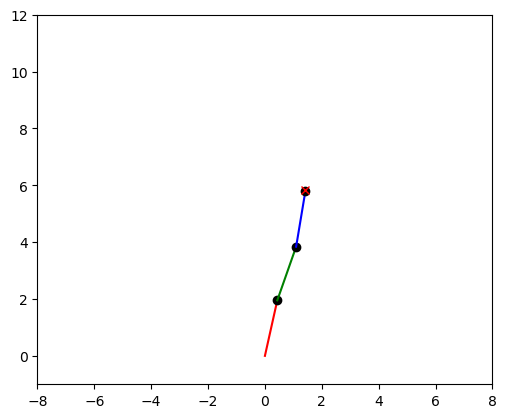

current_x :  1.0538580268621445
current_y :  5.814067959785461
desired_x :  1.0418890714645386
desired_y :  5.908846378326416
joint1_angle:  93.90304808202927
joint2_angle:  -20.676823126238844
joint3_angle:  -1.0688654116436282


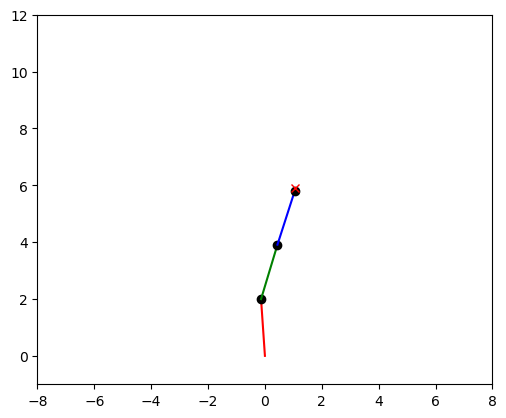

current_x :  0.7262126430869102
current_y :  5.946839094161987
desired_x :  0.6650292277336121
desired_y :  5.963030815124512
joint1_angle:  79.19214657600526
joint2_angle:  3.8551717840799427
joint3_angle:  3.8261716546377045


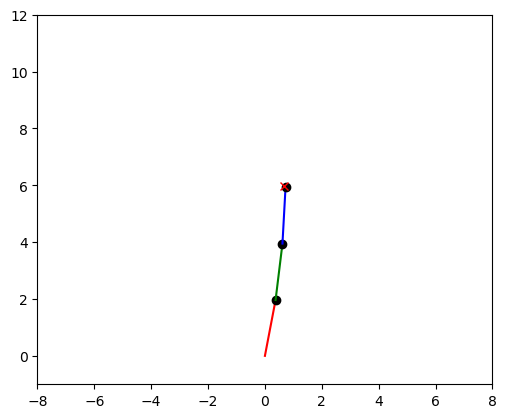

current_x :  0.33228133246302605
current_y :  5.958704829216003
desired_x :  0.2854914963245392
desired_y :  5.993204116821289
joint1_angle:  92.81352544535434
joint2_angle:  -14.071590333748304
joint3_angle:  10.112197064299266


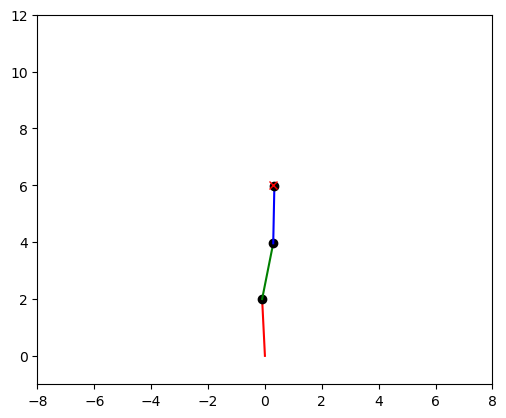

current_x :  -0.011777281761169434
current_y :  5.962593913078308
desired_x :  -0.09519578516483307
desired_y :  5.999244689941406
joint1_angle:  98.58895491311432
joint2_angle:  -9.940637282211242
joint3_angle:  -5.532743738121098


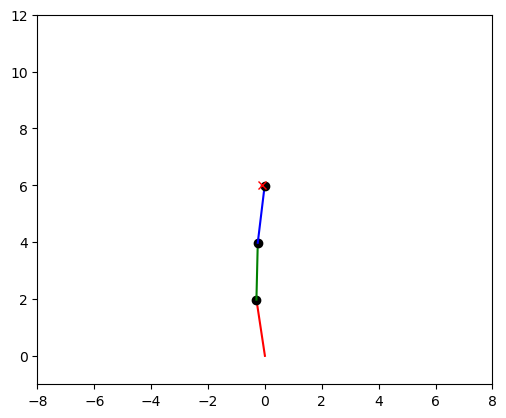

KeyboardInterrupt: 

In [14]:
npooints = 100
theta1 = np.linspace(0, 2*pi, npooints)

R = 6

traj = R*np.cos(theta1) + R * np.sin(theta1)

for the in theta1:
    desx, desy = R*np.cos(the), R*np.sin(the)
    desired_position = np.array([desx, desy ], dtype=np.float32)

    env = RoboticArmEnv(desired_position)
    obs = env.reset(desired_position)
    total_reward = 0
    done = False
    while not done:
        action = env.action_space.sample()
        obs, reward, done, _ = env.step(action)
        total_reward += reward

        # print("Action:", action, "Observation:", obs, "Reward:", reward)
    # print("Total Reward:", total_reward)
    for i, j in zip(['current_x', 'current_y', 'desired_x', 'desired_y', 'joint1_angle', 'joint2_angle', 'joint3_angle'], obs):
        
        if i == 'joint1_angle':
            print("joint1_angle: ", rad_to_deg(j))
        elif i == 'joint2_angle':
            print("joint2_angle: ", rad_to_deg(j))
        elif i == 'joint3_angle':
            print("joint3_angle: ", rad_to_deg(j))
        else:
            print(i, ": ", j)

    # print(obs)
    # print(obs[-3:])
    

    joint_angles = obs[-3:]

    desired_position = obs[2:4]
    arm_length = [2, 2, 2]
    plt.figure()
    plt.plot([0, arm_length[0]*np.cos(joint_angles[0])],
                [0, arm_length[0]*np.sin(joint_angles[0])], 'r-')
    plt.plot([arm_length[0]*np.cos(joint_angles[0])],
                [arm_length[0]*np.sin(joint_angles[0])], 'ko')
    plt.plot([arm_length[0]*np.cos(joint_angles[0]),
                arm_length[0]*np.cos(joint_angles[0]) + arm_length[1]*np.cos(joint_angles[0] + joint_angles[1])],
                [arm_length[0]*np.sin(joint_angles[0]),
                arm_length[0]*np.sin(joint_angles[0]) + arm_length[1]*np.sin(joint_angles[0] + joint_angles[1])], 'g-')
    plt.plot([arm_length[0]*np.cos(joint_angles[0]) + arm_length[1]*np.cos(joint_angles[0] + joint_angles[1])],
                [arm_length[0]*np.sin(joint_angles[0]) + arm_length[1]*np.sin(joint_angles[0] + joint_angles[1])], 'ko')
    plt.plot([arm_length[0]*np.cos(joint_angles[0]) + arm_length[1]*np.cos(joint_angles[0] + joint_angles[1]),
                arm_length[0]*np.cos(joint_angles[0]) + arm_length[1]*np.cos(joint_angles[0] + joint_angles[1]) + arm_length[2]*np.cos(joint_angles[0] + joint_angles[1] + joint_angles[2])],
                [arm_length[0]*np.sin(joint_angles[0]) + arm_length[1]*np.sin(joint_angles[0] + joint_angles[1]),
                arm_length[0]*np.sin(joint_angles[0]) + arm_length[1]*np.sin(joint_angles[0] + joint_angles[1]) + arm_length[2]*np.sin(joint_angles[0] + joint_angles[1] + joint_angles[2])], 'b-')
    plt.plot([arm_length[0]*np.cos(joint_angles[0]) + arm_length[1]*np.cos(joint_angles[0] + joint_angles[1]) + arm_length[2]*np.cos(joint_angles[0] + joint_angles[1] + joint_angles[2])],
                [arm_length[0]*np.sin(joint_angles[0]) + arm_length[1]*np.sin(joint_angles[0] + joint_angles[1]) + arm_length[2]*np.sin(joint_angles[0] + joint_angles[1] + joint_angles[2])], 'ko')
    plt.plot(desired_position[0], desired_position[1], 'rx')
    plt.xlim(-8, 8)
    plt.ylim(-1, 12)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()  

In [10]:
from matplotlib.animation import FuncAnimation
from math import pi
from IPython.display import HTML

[ 0.98681331 -0.18539724 12.33966923]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

# Create some data
x_data = np.linspace(0, 10, 100)
y_data = np.sin(x_data)

# Initialize the figure and axis
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)  # Initialize an empty plot

# Set up the axis limits
ax.set_xlim(0, 10)
ax.set_ylim(-1, 1)

# Define the initialization function
def init():
    line.set_data([], [])
    return line,

# Define the update function
def update(frame):
    x = x_data[:frame]
    y = y_data[:frame]
    line.set_data(x, y)
    return line,

# Create the animation
ani = FuncAnimation(fig, update, frames=len(x_data), init_func=init, blit=True)

# Show the animation
plt.show()
